In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Camera Calibration  

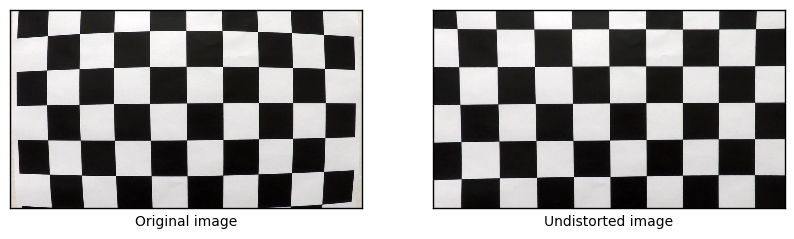

In [9]:
def calibrate_camera_images():
    camera_images = glob.glob('camera_cal/calibration*.jpg')
    # number of corners in x and y axes in calibration chessboard images
    nx, ny = 9, 6 

    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = camera_images[0]
    for fname in camera_images:
        img = cv2.imread(fname) # read image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to gray

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist


camera_mtx, camera_distortion = calibrate_camera_images()

image = mpimage.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(image, camera_mtx, camera_distortion, None, camera_mtx)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Undistorted image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

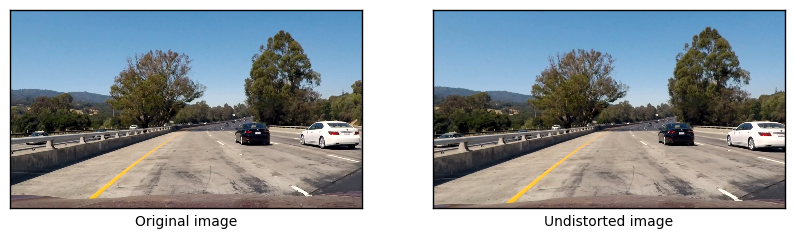

In [11]:
image = mpimage.imread('test_images/test1.jpg')
undistorted_image = cv2.undistort(image, camera_mtx, camera_distortion, None, camera_mtx)
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.xlabel('Undistorted image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Perspective Transform

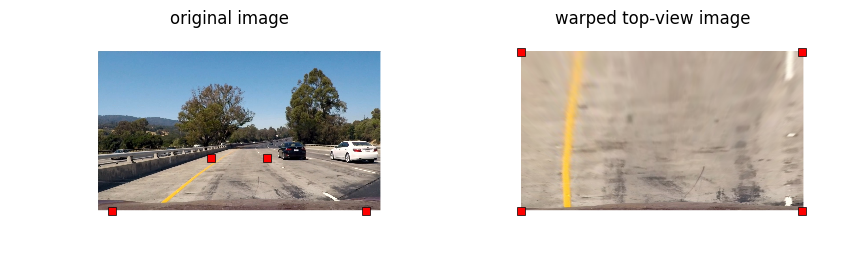

In [13]:
def warp_image(img,src,dst,img_size):
    # perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped,M,Minv

img_size = np.shape(undistorted_image)

# identify the 4 corners to perform perspective transform
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - .2*np.uint(img_size[1]/2)
ctr_window = c_window + .2*np.uint(img_size[1]/2)
cbl_window = c_window - .9*np.uint(img_size[1]/2)
cbr_window = c_window + .9*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

# perform perspective transformation
warped,M_warp,Minv_warp = warp_image(undistorted_image,src,dst,(img_size[1],img_size[0]))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('warped top-view image')
plt.axis('off');

### Color Mask

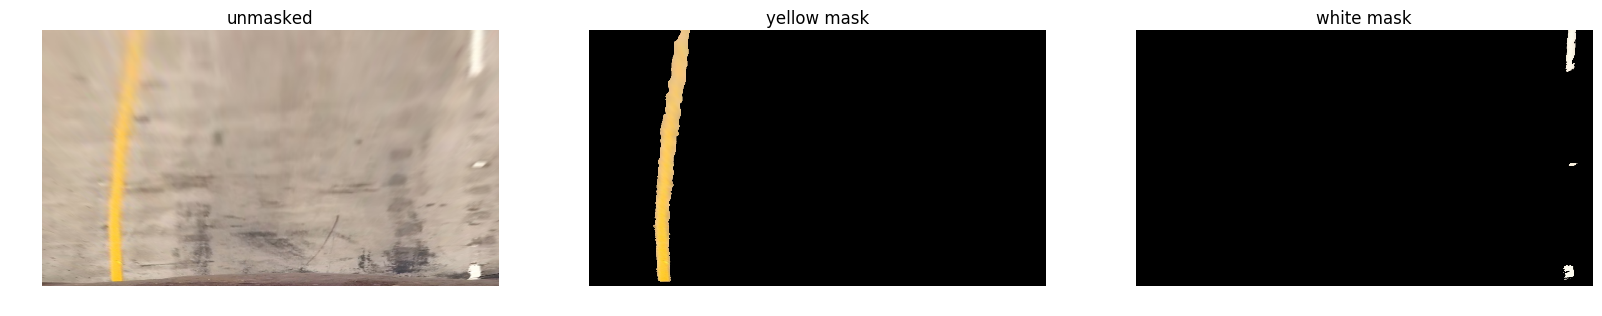

In [205]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])
yellow_mask = cv2.inRange(image_HSV,yellow_hsv_low,yellow_hsv_high)
yellow1 = cv2.bitwise_and(warped, warped, mask=yellow_mask)

white_hsv_low  = np.array([ 18,   9,   240])
white_hsv_high = np.array([ 45,  45, 255])
white_mask = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)
white1 = cv2.bitwise_and(warped, warped, mask=white_mask)

plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(warped)
plt.title('unmasked')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(yellow1)
plt.title('yellow mask')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(white1)
plt.title('white mask')
plt.axis('off');

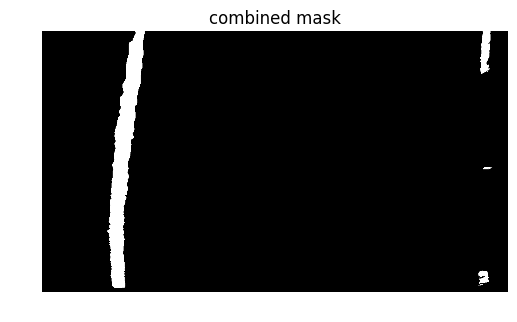

In [199]:
mask_lane = cv2.bitwise_or(yellow_mask,white_mask)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined mask')
plt.axis('off');

### Sobel Filter

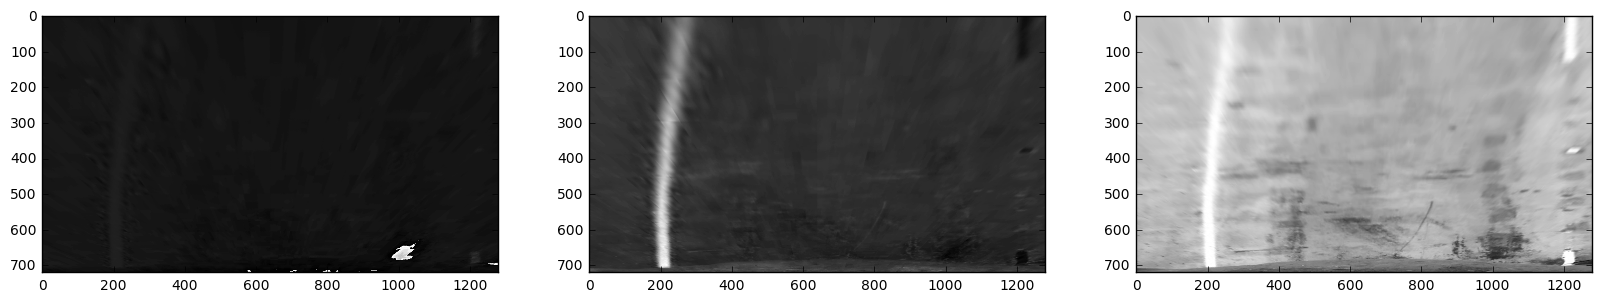

In [226]:
plt.figure(figsize=(20,25))
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

### Sobel Filter on HLS

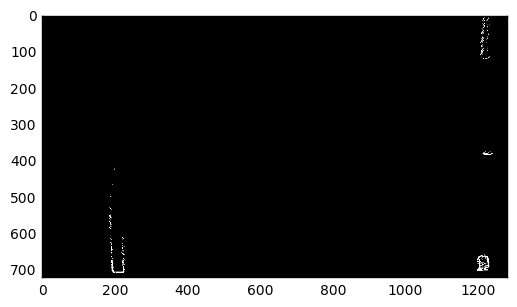

In [232]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def sobel_combined(image):
    # Apply combined sobel filter
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined

img_gs = image_HLS[:,:,1]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
#plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

warped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

img_gs = image_HLS[:,:,2]
#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
sobel_c = sobel_combined(img_gs)
#img_d_mag = dir_threshold(img_gs,3,(.6,1.1))
#img_m_mag = mag_thresh(img_gs,5,(20,265))
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
#plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

warped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

In [239]:
#plt.subplot(1,2,1)
#plt.imshow(warped2,cmap='gray')
#plt.title('Sobel on L channel')
#plt.axis('off')
#plt.subplot(1,2,2)
#plt.title('Sobel on S channel')
#plt.imshow(warped3,cmap='gray')
#plt.axis('off');

In [240]:
image_cmb = cv2.bitwise_or(warped2,warped3)
image_cmb = gaussian_blur(image_cmb,3)
#plt.title('combined L and S sobel filters')
#plt.imshow(image_cmb,cmap='gray')

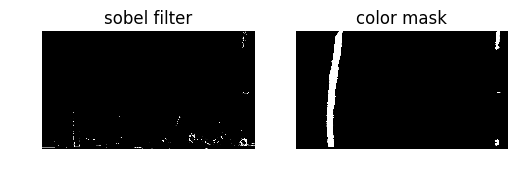

In [244]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
#image_cmb = cv2.bitwise_or(image_cmb,res)
#image_cmb = gaussian_blur(image_cmb,3)

image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('sobel filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('color mask')

(-0.5, 1279.5, 719.5, -0.5)

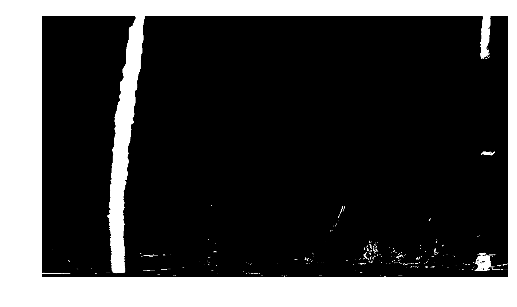

In [245]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')
plt.axis('off')

### Isolate Lanes

(0, 1280)

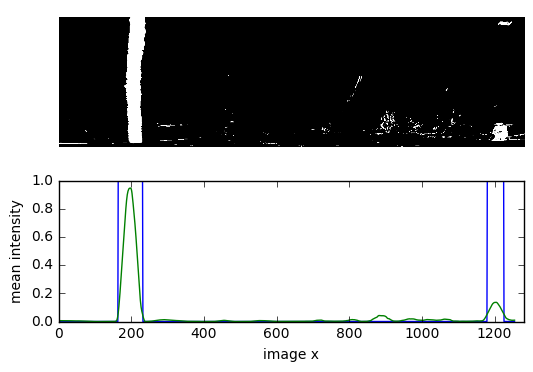

In [246]:
#image_cmb1 = gaussian_blur(image_cmb1,5) 
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)


plt.subplot(2,1,1)
plt.imshow(image_cmb1[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

197 1205


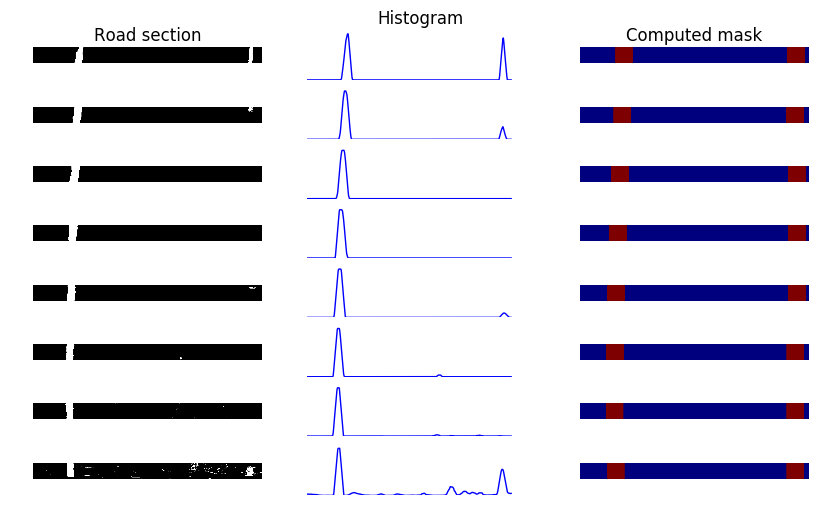

In [247]:
# Get peaks
indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])
window_size=50
val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
ind_sorted = np.argsort(-val_ind)

ind_peakR = indexes[ind_sorted[0]]
ind_peakL = indexes[ind_sorted[1]]
if ind_peakR<ind_peakL:
    ind_temp = ind_peakR
    ind_peakR = ind_peakL
    ind_peakL = ind_temp

n_vals = 8

# Get windows for bottom frame
ind_min_L = ind_peakL-50
ind_max_L = ind_peakL+50

ind_min_R = ind_peakR-50
ind_max_R = ind_peakR+50

mask_L_poly = np.zeros_like(image_cmb1)
mask_R_poly = np.zeros_like(image_cmb1)
print(ind_peakL,ind_peakR)
ind_peakR_prev = ind_peakR
ind_peakL_prev = ind_peakL

plt.figure(figsize=(10,6))
# Slide window up for each 1/8th of image
for i in range(8):
    img_y1 = img_size[0]-img_size[0]*i/8
    img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
    mean_lane_y = np.mean(image_cmb1[img_y2:img_y1,:],axis=0)
    mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
    indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
    
    
    # If 2 peaks are detected assign peaks to correct side.
        
    if len(indexes)>1.5:
        val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
        ind_sorted = np.argsort(-val_ind)

        ind_peakR = indexes[ind_sorted[0]]
        ind_peakL = indexes[ind_sorted[1]]
        if ind_peakR<ind_peakL:
            ind_temp = ind_peakR
            ind_peakR = ind_peakL
            ind_peakL = ind_temp
            
    else:
        # If 1 peak is detected, assign peak to closest peak in previous 1/8th image.
        if len(indexes)==1:
            if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                ind_peakR = indexes[0]
                ind_peakL = ind_peakL_prev
            else:
                ind_peakL = indexes[0]
                ind_peakR = ind_peakR_prev
        else:
            ind_peakL = ind_peakL_prev
            ind_peakR = ind_peakR_prev
            
                
    if np.abs(ind_peakL-ind_peakL_prev)>=100:
        ind_peakL = ind_peakL_prev
    if np.abs(ind_peakR-ind_peakR_prev)>=100:
        ind_peakR = ind_peakR_prev
    
            
    mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
    mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1. 
   
    ind_peakL_prev = ind_peakL
    ind_peakR_prev = ind_peakR
    
    
    

    plt.subplot(8,3,25-3*i-2)
    #plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    plt.plot(mean_lane_y)
    if i==7:
        plt.title('Histogram')
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    plt.axis('off')  
    plt.subplot(8,3,25-3*i-3)
    plt.imshow(image_cmb1[img_y2:img_y1,:],cmap='gray')
    #plt.plot(mean_lane_y)
    #plt.plot(right_pt,pt_y-img_y2,'rs')
    if i==7:
        plt.title('Road section')
    plt.axis('off') 
    plt.subplot(8,3,25-3*i-1)
    plt.imshow(mask_L_poly[img_y2:img_y1,:]+mask_R_poly[img_y2:img_y1,:])
    plt.axis('off')
    if i==7:
        plt.title('Computed mask')

In [248]:
def get_initial_mask(img,window_size):
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = img_size[1]/20.
    mean_ln = np.mean(img[img_size[0]/2:,:],axis=0)
    mean_ln = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_lane,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_size
    ind_max_L = ind_peakL+window_size

    ind_min_R = ind_peakR-window_size
    ind_max_R = ind_peakR+window_size

    mask_L_poly = np.zeros_like(img)
    mask_R_poly = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    diff_R = 0
    diff_L = 0
    for i in range(8):
        

        
        img_y1 = img_size[0]-img_size[0]*i/8
        img_y2 = img_size[0]-img_size[0]*(i+1)/8
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_lane[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
            if len(indexes)==1:
                if np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev+diff_R
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev+diff_R
            else:
                ind_peakL = ind_peakL_prev+diff_R
                ind_peakR = ind_peakR_prev+diff_R
            
                
        if np.abs(ind_peakL-ind_peakL_prev)>=100:
            ind_peakL = ind_peakL_prev
        if np.abs(ind_peakR-ind_peakR_prev)>=100:
            ind_peakR = ind_peakR_prev
    
            
        mask_L_poly[img_y2:img_y1,ind_peakL-window_size:ind_peakL+window_size] = 1.     
        mask_R_poly[img_y2:img_y1,ind_peakR-window_size:ind_peakR+window_size] = 1.
        
        if i == 0:
            window_size= window_size/1
   
        if i>0:
            diff_R = ind_peakL-ind_peakL_prev
            diff_L = ind_peakR-ind_peakR_prev

    
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
        
        
    return mask_L_poly,mask_R_poly

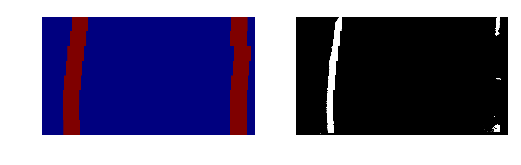

In [249]:
mask_L_poly,mask_R_poly = get_initial_mask(image_cmb1,50)

plt.subplot(1,2,1)
plt.imshow(mask_R_poly+mask_L_poly)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(cv2.bitwise_and(image_cmb1,image_cmb1,mask=mask_R_poly+mask_L_poly),cmap='gray')

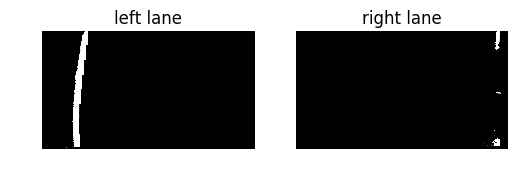

In [251]:
mask_L = mask_L_poly

img_L = np.copy(image_cmb1)
img_L = cv2.bitwise_and(img_L,img_L,mask=mask_L_poly)


mask_R = mask_R_poly

img_R = np.copy(image_cmb1)
img_R = cv2.bitwise_and(img_R,img_R,mask=mask_R_poly)
#img_L = gaussian_blur(img_L,5)
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.axis('off')
plt.title('left lane')
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.axis('off')
plt.title('right lane');

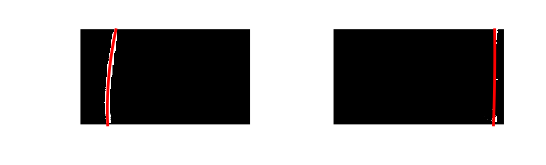

In [252]:
vals = np.argwhere(img_L>.5)
all_x = vals.T[0]
all_y =vals.T[1]

left_fit = np.polyfit(all_x, all_y, 2)
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]



# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L,cmap='gray')
plt.plot( left_fitx,left_y,'red',linewidth=2)
plt.axis('off');

vals = np.argwhere(img_R>.5)

all_x = vals.T[0]
all_y =vals.T[1]

right_fit = np.polyfit(all_x, all_y, 2)
right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]



# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx,right_y,'r',linewidth=2)
plt.axis('off');

In [272]:
warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))


cv2.fillPoly(color_warp, np.int_([pts]), (255, 149, 0))

col_L = (255,255,0)
col_R = (255,255,255)    

draw_pw_lines(color_warp,np.int_(pts_left),col_L)
draw_pw_lines(color_warp,np.int_(pts_right),col_R)


newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 


result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.5, 0)

(-0.5, 1279.5, 719.5, -0.5)

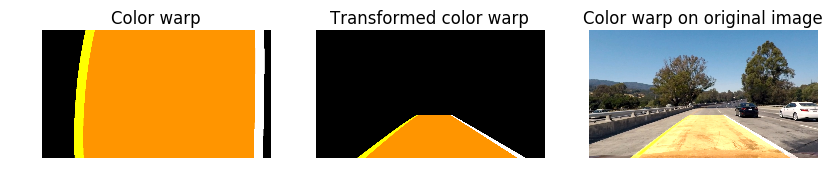

In [273]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')
plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on original image')
plt.axis('off')

### Putting it all together

In [283]:
import cv2
import glob
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
#%load_ext line_profiler

def calibrate_camera(cal_images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def camera_setup():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    nx, ny = 9, 6
    cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist

def get_perspective_transform(image, src_in = None, dst_in = None, display=False):
    img_size = image.shape
    if src_in is None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        src = src_in
        
    if dst_in is None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        dst = dst_in
        
    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)

    if display:
        plt.subplot(1,2,1)
        plt.hold(True)
        plt.imshow(image, cmap='gray')
        colors = ['r+','g+','b+','k+']
        for i in range(4):
            plt.plot(src[i,0],src[i,1],colors[i],mew=2,ms=10)
        
        plt.xticks([],[])
        plt.yticks([],[])
        plt.xlabel('Original image with source points')
        
        im2 = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)
        plt.hold(True)
        plt.imshow(im2, cmap='gray')
        for i in range(4):
            plt.plot(dst[i,0],dst[i,1],colors[i],mew=2,ms=10)
        
        plt.xticks([],[])
        plt.yticks([],[])
        plt.xlabel('Warped image with destination points')
        
        plt.show()
    return warp_m, warp_minv

def find_perspective_points(image):
    edges = find_edges(image, True)
    
    # Computing perspective points automatically
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 100       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 # minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments

    angle_min_mag = 20*pi/180
    angle_max_mag = 65*pi/180

    lane_markers_x = [[], []]
    lane_markers_y = [[], []]
    
    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0]*6//10,:] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                if theta > 0: # positive theta is downward in image space?
                    i = 0 # Left lane marker
                else:
                    i = 1 # Right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        # Failed to find two lane markers
        return None
    
    
    p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)
    
    # Find intersection of the two lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075*edges.shape[0])
    
    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))
    
    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    get_perspective_transform(edges, src_in = src, dst_in = None, display=False) 
    return src

def find_edges(image, ksize = 11, mask_half=False):
    
#     blur = cv2.GaussianBlur(image, (ksize, ksize), 0)
    hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
#     gray = cv2.cvtColor(blur.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
    s = hls[:,:,2]
    
    _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

    total_px = image.shape[0]*image.shape[1]
    laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
    mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
    if cv2.countNonZero(mask_three)/total_px < 0.01:
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

    _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
    mask_two = s_binary

    combined_binary = np.clip(cv2.bitwise_and(gray_binary, 
                        cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

    # Mask out top half of image to reduce distractions
    # Only used when unwarped image is passed in
    if mask_half:
        print(ceil(image.shape[0]//2))
        combined_binary[:ceil(image.shape[0]//2)] = 0
#     else:
#         plt.subplot(2, 3, 1)
#         plt.imshow(s_binary, cmap='gray')
#         plt.subplot(2, 3, 2)
#         plt.imshow(mask_three, cmap='gray')
#         plt.subplot(2, 3, 3)
#         plt.imshow((laplacian), cmap='gray')
#         plt.subplot(2, 3, 4)
#         plt.imshow(gray_binary, cmap='gray')
#         plt.subplot(2, 3, 5)
#         plt.imshow(cv2.equalizeHist(s), cmap='gray')
#         plt.subplot(2, 3, 6)
#         plt.imshow(combined_binary, cmap='gray')

    return combined_binary


import collections
from itertools import chain, repeat
from functools import reduce

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension

class Lane():
    def __init__(self, base_pt, img_size, cache_length):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=cache_length)
        self.recent_yfitted = collections.deque(maxlen=cache_length)
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.insanity = 0.0 
                
        self.current_xfit = None
        self.roi_mask = None
        
        self.img_size = img_size
        self.base_pt = base_pt
        
        self.yvals = np.linspace(0, img_size[0], 101)
        self.mask = np.ones(img_size, dtype=np.uint8)*255
        
        self.dropped_frames = 0
    
    def add_lane_pixels(self, x, y):
        # Use all pixels from previous detections for curve fit
        weights = np.ones(len(self.recent_xfitted))
        if len(weights) > 1:
            weights[0] = 0.8
            weights[1:] = 0.2/(len(weights) - 1)

            w_x = reduce(lambda a,b: a + b[0]*b[1], zip(weights, self.recent_xfitted), np.zeros(len(self.yvals)))
            w_y = reduce(lambda a,b: a + b[0]*b[1], zip(weights, self.recent_yfitted), np.zeros(len(self.yvals)))
        else:
            w_x, w_y = [], []
        x_hist = np.fromiter(chain(w_x, x), np.int32)
        y_hist = np.fromiter(chain(w_y, y), np.int32)

        try:
            p_lane = np.polyfit(y_hist, x_hist, 2)
            rad_curv = self.compute_rad_curv(x_hist, y_hist)
            self.detected = self.sanity_check_lane(rad_curv)
        except Exception as e:
            print(e)
            self.detected = False

        if self.detected and len(p_lane) == 3:
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]

            self.current_xfit = x_fit   # For drawing

            self.recent_xfitted.append(x_fit)
            self.recent_yfitted.append(self.yvals)

            self.radius_of_curvature = rad_curv
            self.current_fit = p_lane
            self.dropped_frames = 0
        else:
            # Sanity check failed
            # Use last fit if current one failed
            p_lane = self.current_fit
            rad_curv = self.radius_of_curvature
            x_fit = p_lane[0]*self.yvals**2 + p_lane[1]*self.yvals + p_lane[2]
            self.dropped_frames += 1

        # Update ROI mask
        self.mask.fill(0)
        # http://stackoverflow.com/a/35902430/538379
        pts = np.transpose(np.vstack([x_fit, self.yvals])).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(self.mask, pts, -1, (255,255,255), thickness=80)
        
    @staticmethod
    def compute_rad_curv(xvals, yvals):
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        y_eval = np.max(yvals)
        curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
        
        
    def sanity_check_lane(self, R):
        """
        Checks new radius of curvature `R` against the radius stored in the object.
        """
        # Return true if there is no prior data
        if self.radius_of_curvature is None:
            return True
        
        k = 1/R   # Curvature is a better measure to track
        R0 = self.radius_of_curvature
        k0 = 1/self.radius_of_curvature
#         return abs(k-k0)/k0 <= 0.05
#         self.insanity = abs(k-k0)/k0
        self.insanity = abs(R-R0)/R0
        return self.insanity <= 0.5  # Max change from frame to frame is 200%
            
        
    def detect_from_mask(self, image):
        mask_lanes = cv2.bitwise_and(image, self.mask)
        all_pts = cv2.findNonZero(mask_lanes)
        if all_pts is not None:
            all_pts = all_pts.reshape((-1,2))
            self.add_lane_pixels(all_pts[:,0], all_pts[:,1])
        else:
            self.detected = False
        
    def draw_lane(self, image):
        """
        Draws lane on given image
        """
        pts = np.array([np.transpose(np.vstack([self.current_xfit, self.yvals]))])
        cv2.fillPoly(image, np.int_([pts]), (0,255, 0))
        return image
    
def reject_outliers(x_list, y_list):
    if not x_list or not y_list:
        return x_list, y_list
    mu_x, mu_y = np.mean(x_list), np.mean(y_list)
    sig_x, sig_y = np.std(x_list), np.std(y_list)
    new_x, new_y = zip(*[(x, y) for (x,y) in zip(x_list, y_list) 
                                 if abs(x - mu_x) < 2*sig_x and abs(y - mu_y) < 2*sig_y])
    return new_x, new_y

def histogram_lane_detection(image, left_lane, right_lane, base_pts, num_bands = 10, window_width = 0.2):
    """Uses histogram and sliding window to detect lanes from scratch"""

    height = image.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(window_width*image.shape[1])
    
    l_x, l_y, r_x, r_y = [], [], [], []
    
    base_left, base_right = base_pts

    idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = image[i*band_height:(i+1)*band_height,base_left-band_width//2:base_left+band_width//2]
        w_right = image[i*band_height:(i+1)*band_height,base_right-band_width//2:base_right+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + base_left-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ base_right-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left-band_width//2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right-band_width//2

    l_x, l_y = reject_outliers(l_x, l_y)
    r_x, r_y = reject_outliers(r_x, r_y)
    
    left_lane.add_lane_pixels(l_x, l_y)
    right_lane.add_lane_pixels(r_x, r_y)

    return left_lane, right_lane

from scipy.signal import find_peaks_cwt

def find_base_points(lanes, min_peak = 25.0):
    """Uses histogram to find possible base points for lane lines"""
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)
    
    widths = [100]
    idx = find_peaks_cwt(hist, widths, max_distances=widths, noise_perc=50) 
    if len(idx) < 2:
        return None

    # Avoid edges
    idx = [i for i in idx if i > lanes.shape[1]*0.1
                             and i < lanes.shape[1]*0.9
                             and max(hist[i-50:i+50]) > min_peak]        
#     middle = np.average(idx)
#     left_pt = max(i for i in idx if i < middle)   # Closest peak to middle on the left    
#     right_pt = min(i for i in idx if i >= middle) # Closest peak to middle on the right
    return [min(idx), max(idx)], hist

def process_image(image, key_frame_interval=20, cache_length=10):
    global cam_mtx, cam_dist
    
    if process_image.cache is None:
                
        left_lane = Lane(int(0.16*image.shape[0]), image.shape[:2], cache_length=cache_length)
        right_lane = Lane(int(0.62*image.shape[0]), image.shape[:2], cache_length=cache_length)

        cache = {'cam_mtx': cam_mtx,
                 'cam_dist': cam_dist,
                 'warp_m': None,
                 'warp_minv': None,
                 'frame_ctr': 0,
                 'left': left_lane,
                 'right': right_lane,
                 'base_pts': None}
    else:
        cache = process_image.cache
    

    left_lane = cache['left']
    right_lane = cache['right']

    # Preprocess image and find edges using thresholding
    undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    
    if cache['warp_m'] is None:# or cache['frame_ctr'] % key_frame_interval == 0:
        src = find_perspective_points(undist)
        warp_m, warp_minv = get_perspective_transform(image, src_in = src)
        
        if src is not None:
            # Save only if customized perspective transform is found
            cache['warp_m'] = warp_m
            cache['warp_minv'] = warp_minv
    else:
        warp_m, warp_minv = cache['warp_m'], cache['warp_minv']
    
    warp_img = cv2.warpPerspective(undist, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    warp_edges = find_edges(warp_img)
    
    base_pts = cache['base_pts']
    if base_pts is None: #or cache['frame_ctr'] % key_frame_interval == 0:
        new_base_pts, _ = find_base_points(warp_edges)

        if new_base_pts is not None:
            base_pts = new_base_pts
        else:
            # Could not find new base points
            # Re-use previous data if base points could not be found
            cache['frame_ctr'] = cache['frame_ctr'] - 1 # Make sure we try again in the next frame
            return undist

    if ((left_lane.current_xfit is None or left_lane.dropped_frames > 16) 
            or (right_lane.current_xfit is None or right_lane.dropped_frames > 16)):
        # Detect from scratch
        left_lane.radius_of_curvature = None
        right_lane.radius_of_curvature = None
        histogram_lane_detection(warp_edges, left_lane, right_lane, base_pts)
    else:
        left_lane.detect_from_mask(warp_edges)
        right_lane.detect_from_mask(warp_edges)

    cache['frame_ctr'] = cache['frame_ctr'] + 1
    cache['base_pts'] = base_pts
    process_image.cache = cache
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)
    
    yvals = left_lane.yvals
    left_fitx = left_lane.current_xfit
    right_fitx = right_lane.current_xfit
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))    

    # Draw lane markers
    pts = np.transpose(np.vstack([left_lane.current_xfit, left_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_lane.current_xfit, right_lane.yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, warp_minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    left_r = left_lane.radius_of_curvature
    right_r = right_lane.radius_of_curvature
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = image.shape[1]//2
    
    dx = (veh_pos - middle)*xm_per_pix # Positive if on right, Negative on left

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left radius of curvature  = %.2f m'%(left_r),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right radius of curvature = %.2f m'%(right_r),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)

    is_tracking = left_lane.detected or right_lane.detected
    cv2.putText(result,'Tracking Locked' if is_tracking else 'Tracking Lost',(50,140),
            font, 1,(0,255,0) if is_tracking else (255,0,0), 3,cv2.LINE_AA)

    plt.subplot(1,2,1)
    plt.imshow(left_lane.mask, cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel('Left lane mask')

    plt.subplot(1,2,2)
    plt.imshow(right_lane.mask, cmap='gray')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.xlabel('Right lane mask')
    
    cache['left'] = left_lane
    cache['right'] = right_lane

    return result

def clear_cache():
    process_image.cache = None
    

In [286]:
cam_mtx, cam_dist = camera_setup()

vid_output = 'project_video_result.mp4'
clip = VideoFileClip('project_video.mp4')

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [03:29<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 13min 1s, sys: 1min 4s, total: 14min 5s
Wall time: 3min 30s


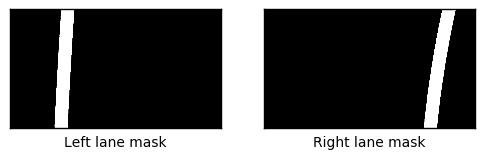

In [287]:
clear_cache()
vid_clip = clip.fl_image(process_image)
%time vid_clip.write_videofile(vid_output, audio=False)